# Libraries Setup

In [10]:
import os
#os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import pickle
import numpy as np
import pandas as pd
from PIL import ImageFont

from geexhp import datasetup as dset
from geexhp import datavis, cnn1d
datavis.configure_matplotlib()

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import visualkeras
from tensorflow.keras.utils import plot_model # type: ignore
from tensorflow.keras.models import Model

# Data Setup

In [3]:
#folder = "../parallel/data/"
#df = dset.combine_parquet(folder=folder, keyword="_", output_file=True)

In [2]:
df = pd.read_parquet("../data/__data.parquet")

In [3]:
dfabun = dset.extract_abundances(df)
dfabun.dropna(inplace=True)

# Preprocessing data and creating the training and testing datasets

In [4]:
X = np.array([np.array(d) for d in dfabun['ALBEDO'].to_numpy()])
y = dfabun[["ATMOSPHERE-PRESSURE","ATMOSPHERE-TEMPERATURE", "OBJECT-DIAMETER", 
            "OBJECT-GRAVITY","C2H6","CH4","CO","CO2","H2","H2O","HCN","N2",
            "N2O","NH3","O2","O3","PH3"]]
wavelengths = dfabun["WAVELENGTH"][0]

In [5]:
start_wavelength = wavelengths.min()
end_wavelength = wavelengths.max()
num_bins = 10

bin_size = (end_wavelength - start_wavelength) / num_bins
wavelength_bins = [(start_wavelength + i * bin_size, start_wavelength + (i + 1) * bin_size) for i in range(num_bins)]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
#X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, _, y_scaler = dset.windowed_normalization(
#    X_train, X_test, y_train, y_test, wavelengths, wavelength_bins
#)

Train input shape: (31800, 2304, 1)
Test input shape: (7951, 2304, 1)
Train labels shape: (31800, 17)
Test labels shape: (7951, 17)


In [11]:
#saving = {
#    "X_train_scaled": X_train_scaled,
#    "X_test_scaled": X_test_scaled,
#    "y_train_scaled": y_train_scaled,
#    "y_test_scaled": y_test_scaled
#}

#for name, data in saving.items():
#    np.save(f"../models/{name}.npy", data)

#with open("../models/scalers.pkl", "wb") as f:
#    pickle.dump({"x_scalers": _, "y_scaler": y_scaler}, f)

#print("Data and scalers saved successfully.")

Data and scalers saved successfully.


In [12]:
X_train_scaled = np.load('../models/X_train_scaled.npy')
X_test_scaled = np.load('../models/X_test_scaled.npy')
y_train_scaled = np.load('../models/y_train_scaled.npy')
y_test_scaled = np.load('../models/y_test_scaled.npy')

with open('../models/scalers.pkl', 'rb') as f:
    scalers = pickle.load(f)
    x_scalers = scalers['x_scalers']
    y_scaler = scalers['y_scaler']

print("Data and scalers loaded successfully.")

Data and scalers loaded successfully.


# Convolutional Neural Network 1D (CNN) 

In [13]:
input_shape = X_train_scaled.shape[1:]
output_units = y_train_scaled.shape[1]
conv_layers = [(16, 3, 2), (32, 5, 8), (64, 5, 16)]
dense_layers = [64, 32, 16]

cnn = cnn1d.ConvolutionalNetwork(input_shape, output_units, conv_layers, dense_layers)

In [14]:
history = cnn.train(X_train_scaled, y_train_scaled, epochs=50, batch_size=64)

Epoch 1/50
398/398 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 1.1615
Epoch 1: saving model to ../models/weights.weights.h5
398/398 ━━━━━━━━━━━━━━━━━━━━ 135s 330ms/step - loss: 1.1611 - val_loss: 0.9016
Epoch 2/50
398/398 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - loss: 0.9135
Epoch 2: saving model to ../models/weights.weights.h5
398/398 ━━━━━━━━━━━━━━━━━━━━ 133s 334ms/step - loss: 0.9135 - val_loss: 0.6914
Epoch 3/50
398/398 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - loss: 0.8631
Epoch 3: saving model to ../models/weights.weights.h5
398/398 ━━━━━━━━━━━━━━━━━━━━ 131s 329ms/step - loss: 0.8630 - val_loss: 0.6728
Epoch 4/50
398/398 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - loss: 0.8954
Epoch 4: saving model to ../models/weights.weights.h5
398/398 ━━━━━━━━━━━━━━━━━━━━ 133s 333ms/step - loss: 0.8952 - val_loss: 0.6605
Epoch 5/50
398/398 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - loss: 0.8206
Epoch 5: saving model to ../models/weights.weights.h5
398/398 ━━━━━━━━━━━━━━━━━━━━ 132s 332ms/step - loss: 0.8206 - val_los

In [ ]:
cnn.plot_losses(history)

# Tuning hyperparameters

In [12]:
#tuner = cnn1d.CNNHyperparameterTuner(input_shape=input_shape, output_units=output_units)
#model = tuner.tune_model(X_train_scaled, y_train_scaled)
#best_model = tuner.get_best_model()
#best_model.save('../models/best_cnn_model.keras')

I completed this part using Colab:

In [13]:
cnn.load_model('../models/best_cnn_model.keras')

/home/sarah/Documentos/PSGCode/psg-venv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [14]:
cnn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Albedo (InputLayer)             │ (None, 2304, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 2300, 224)      │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2300, 224)      │           896 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 2300, 224)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1148, 224)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1146, 32)       │        21,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1146, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 1146, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 571, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18272)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 448)            │     8,186,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        28,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 17)             │         1,105 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,719,125 (94.30 MB)

 Trainable params: 8,239,537 (31.43 MB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 16,479,076 (62.86 MB)

I0000 00:00:1726079482.593782   45628 service.cc:146] XLA service 0x70b5bc02a2d0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726079482.593812   45628 service.cc:154]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1726079482.743670   45628 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


249/249 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step


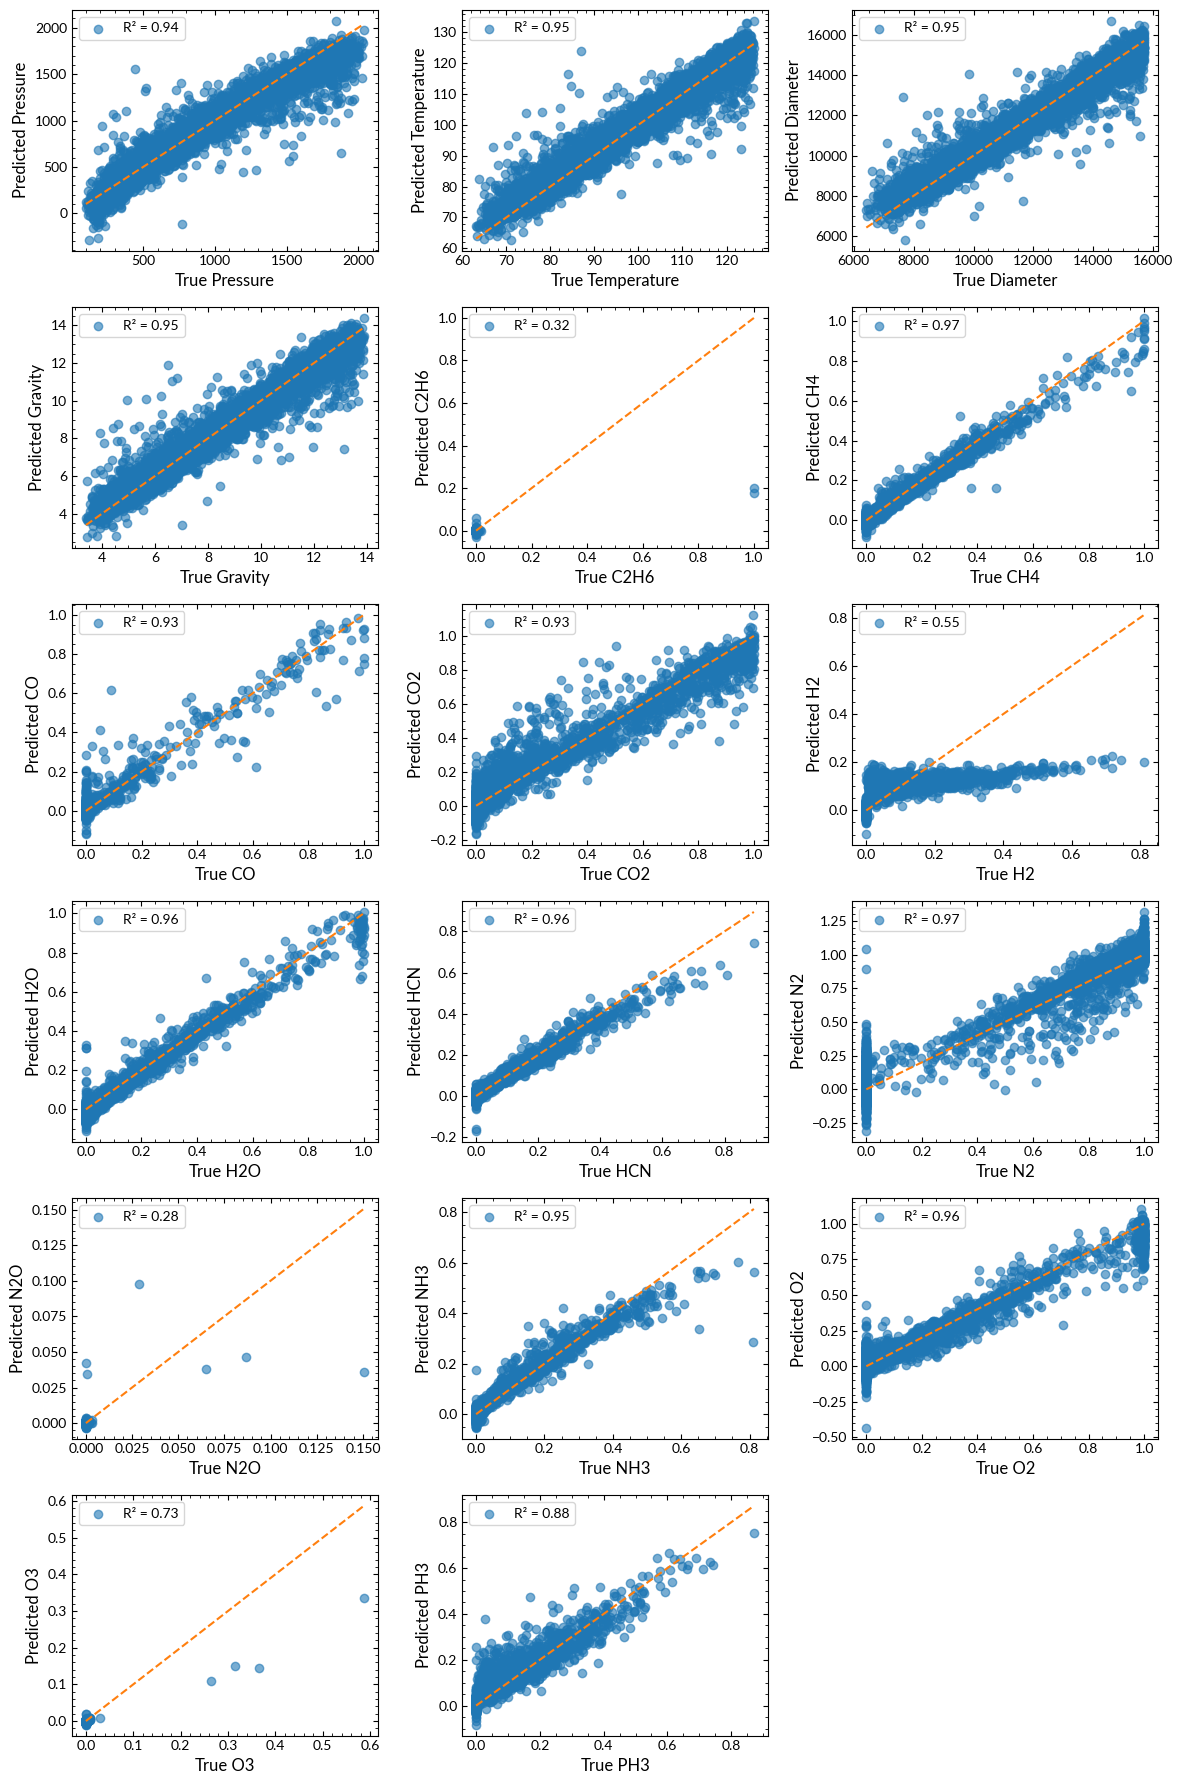

,R² scores,MAE scores,RMSE scores
Pressure,0.94,85.96,123.95
Temperature,0.95,2.62,3.70
Diameter,0.95,368.13,522.61
Gravity,0.95,0.40,0.58
C2H6,0.32,0.00,0.01
CH4,0.97,0.01,0.02
CO,0.93,0.01,0.02
CO2,0.93,0.04,0.06
H2,0.55,0.02,0.05
H2O,0.96,0.02,0.03


In [15]:
features_names = ["Pressure", "Temperature", "Diameter", "Gravity", "C2H6","CH4",
                "CO","CO2","H2","H2O","HCN","N2","N2O","NH3", "O2","O3","PH3"]
cnn.evaluate(X_test_scaled, y_test_scaled, features_names, y_scaler)

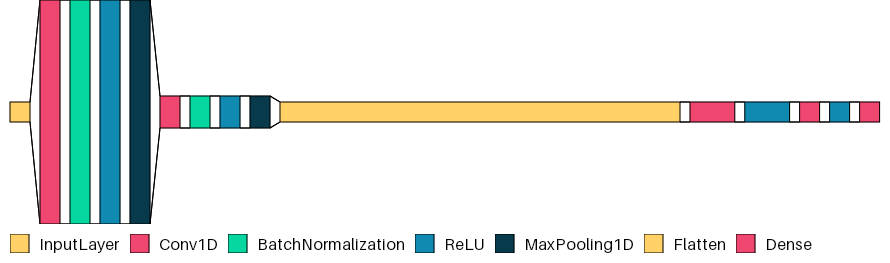

In [16]:
font = ImageFont.load_default(size = 16)

visualkeras.layered_view(cnn.model, to_file='../images/model_architecture.png', legend=True,
                        draw_funnel=True, draw_volume=False,
                        one_dim_orientation="z", scale_xy=1, font=font)

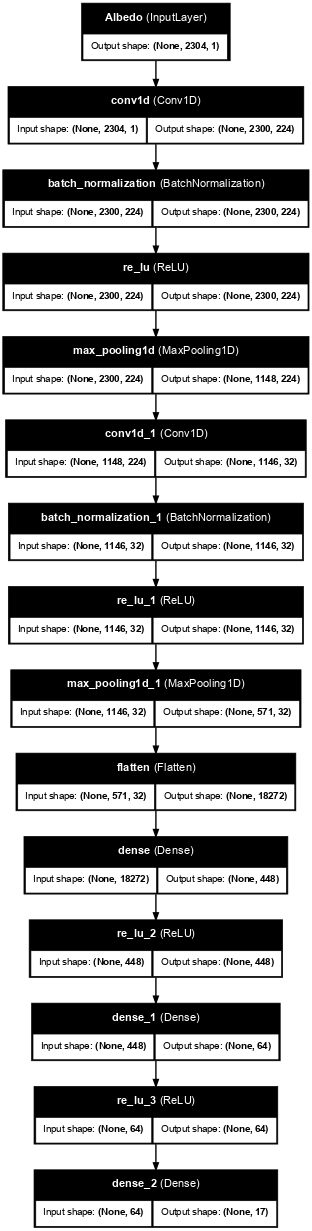

In [17]:
plot_model(cnn.model, to_file='../images/model.png', show_shapes=True, show_layer_names=True,  rankdir='TB', expand_nested=False, dpi=50)

In [71]:
layer_names = [layer.name for layer in cnn.model.layers if 'conv' in layer.name]
feature_map_model = Model(inputs=cnn.model.input, outputs=[cnn.model.get_layer(name).output for name in layer_names])

In [75]:
single_input = np.expand_dims(X_test_scaled[5], axis=0)
feature_maps = feature_map_model.predict(single_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


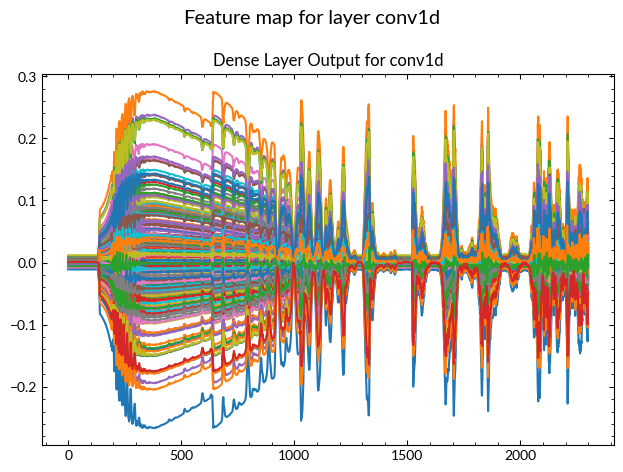

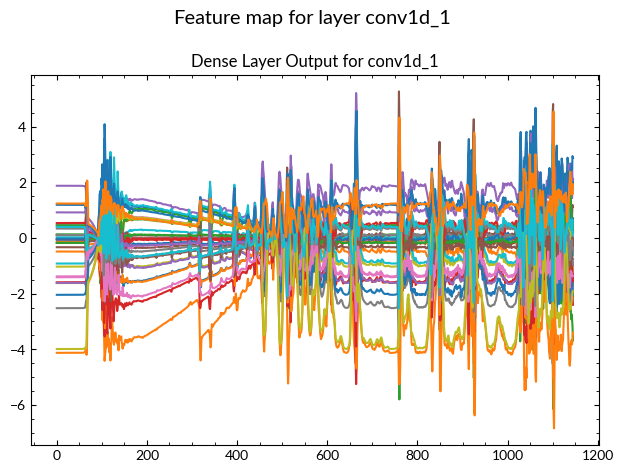

In [76]:
for layer_name, feature_map in zip(layer_names, feature_maps):
    num_neurons = feature_map.shape[-1]  

    plt.suptitle(f"Feature map for layer {layer_name}")

    plt.plot(feature_map[0])
    plt.title(f"Dense Layer Output for {layer_name}")

    plt.tight_layout()
    plt.show()

In [82]:
num_filters = feature_map.shape[-1]
filter_activations = [np.sum(np.abs(feature_map[0, :, i])) for i in range(num_filters)]
important_filters = np.argsort(filter_activations)[::-1]
print(f"Most active filters in {layer_name}: {important_filters[:5]}")

Most active filters in conv1d_1: [21 28 13 11  4]


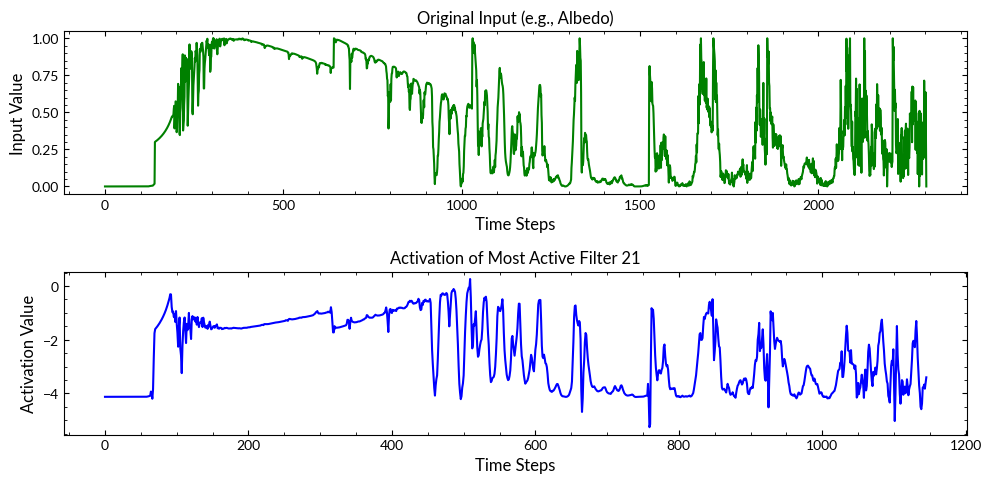

In [84]:
# Plot the original input data (scaled or raw) alongside the most active filter's activation
plt.figure(figsize=(10, 5))

# Plot the input
plt.subplot(2, 1, 1)
plt.plot(single_input[0, :, 0], color='green')
plt.title('Original Input (e.g., Albedo)')
plt.xlabel('Time Steps')
plt.ylabel('Input Value')

# Plot the activation of the most active filter
plt.subplot(2, 1, 2)
plt.plot(feature_map[0, :, important_filters[0]], color='blue')
plt.title(f'Activation of Most Active Filter {important_filters[0]}')
plt.xlabel('Time Steps')
plt.ylabel('Activation Value')

plt.tight_layout()
plt.show()